# FINAL NPZD PROTOTYPE

# done:
- completely rewrote handling of fluxes, this time registered with decorator
- add option to include all output vars to phyda.setup wrapper!
- add "group" multi flux, that can be appended to modularly (i.e. growth with monod, light-lim, etc.)
- make "group" function work with the other solvers (Stepwise + GEKKO)
    note: there is an error if I store the state of constant fluxes that are added in group_to_arg flux in odeint
    this is due to odeint errors, and I could not find a quick fix: shows importance of using different solvers!
- add "list input" of multiple vars for grazing flux!

     

In [1]:
import os,sys,inspect
sys.path.insert(1, os.path.join(sys.path[0], '..'))

import phydra

In [2]:
from phydra.components.variables import SV
from phydra.components.fluxes import (LinearForcingInput, LinearMortalityExchange,
                                      QuadraticMortality,
                                      ExponentialGrowth, MonodGrowth,
                                      HollingTypeIII, HollingTypeIII_2Resources,
                                      Growth_Monod_Eppley_Steele)
from phydra.components.forcings import ConstantForcing, SinusoidalForcing, GlobalSlabClimatologyForcing

In [3]:
import numpy as np

In [4]:
NPZD = phydra.create({'Nutrient':SV, 
                      'Phytoplankton':SV,
                      'Zooplankton':SV,
                      'Detritus':SV,

                      'Input':LinearForcingInput, 
                      'Mortality':LinearMortalityExchange, 'QuadMortality':QuadraticMortality,

                      'Growth':Growth_Monod_Eppley_Steele,
                      'Grazing':HollingTypeIII_2Resources,
                      
                      # HERE NEED TO ADD THIS:
                      'N0':GlobalSlabClimatologyForcing,
                      'Tmld':GlobalSlabClimatologyForcing,
                      'I0':GlobalSlabClimatologyForcing,
                      'MLD':GlobalSlabClimatologyForcing
                     })

In [5]:
NPZD

<xsimlab.Model (16 processes, 64 inputs)>
Core
    solver_type       [in]
Time
    time              [in] ('input_time',) sequence of time points ...
Nutrient
    var_label         [in] label / basic state variable
    var_init          [in] initial value / basic state variable
Phytoplankton
    var_label         [in] label / basic state variable
    var_init          [in] initial value / basic state variable
Zooplankton
    var_label         [in] label / basic state variable
    var_init          [in] initial value / basic state variable
Detritus
    var_label         [in] label / basic state variable
    var_init          [in] initial value / basic state variable
Tmld
    forcing_label     [in] label / 
    lon               [in] constant value of forcing
    rbb               [in] constant value of forcing
    smooth            [in] smoothing conditions, larger values = st...
    lat               [in] constant value of forcing
    dataset           [in] Options: 'n0x', 'mld', 'tmld

'N0':{'lat':47,'lon':-20,'rbb':2,'smooth':5, 'k':2,
       'dataset':'n0x', 'show_plot':True},
'Temp':{'lat':47,'lon':-20,'rbb':2,'smooth':5, 'k':2,
       'dataset':'tmld', 'show_plot':True},
'I0':{'lat':47,'lon':-20,'rbb':2,'smooth':10, 'k':2,
       'dataset':'par', 'show_plot':True},
'MLD':{'lat':47,'lon':-20,'rbb':2,'smooth':400, 'k':2,
       'dataset':'mld', 'show_plot':True}

In [6]:
odeint_setup = phydra.setup('odeint', NPZD,
            time=np.arange(0,365*5),
            input_vars={
                'Nutrient':{'var_label':'N','var_init':1.},
                'Phytoplankton':{'var_label':'P','var_init':1.},
                'Zooplankton':{'var_label':'Z','var_init':1.},
                'Detritus':{'var_label':'D','var_init':1.},
                
                'Input':{'var':'N','rate':0.1, 'forcing':'N0'},
                
                'Mortality':{'source':'P', 'sink':'D', 'rate':0.1},
                'QuadMortality':{'var':'Z', 'rate':0.01},
                
                'Growth':{'consumer':'P', 'resource':'N', 
                          'Temp':'Tmld', 'Light':'I0', 'MLD':'MLD',
                          'kw':0.04, 'kc':0.03,
                          'μ_max':1., 'halfsat':1.5, 'eppley':0.063, 'i_opt':2},
                
                'Grazing':{'r_1':'P', 'r_2':'D', 'consumer':'Z',
                           'fp_1':.5, 'fp_2':.5,'Imax':1., 'kZ':1.5},
                
                'N0':{'forcing_label':'N0', 'dataset':'n0x',
                      'lat':47,'lon':-20,'rbb':2,
                      'smooth':5, 'k':2},
                'Tmld':{'forcing_label':'Tmld', 'dataset':'tmld',
                      'lat':47,'lon':-20,'rbb':2,
                      'smooth':5, 'k':2},
                'I0':{'forcing_label':'I0', 'dataset':'par',
                      'lat':47,'lon':-20,'rbb':2,
                      'smooth':10, 'k':2},
                'MLD':{'forcing_label':'MLD', 'dataset':'mld',
                      'lat':47,'lon':-20,'rbb':2,
                      'smooth':400, 'k':2},
            },
            output_vars="ALL"
            )

In [7]:
with NPZD:
    odeint_out = odeint_setup.xsimlab.run()

initializing model backend
Initializing Model Time
Initializing component Nutrient
returning input arg dict defaultdict(<class 'list'>, {'vars': [{'var': 'var', 'label': 'N'}]})
defaultdict(<class 'list'>, {'vars': [{'var': 'var', 'label': 'N'}]})
Initializing component Phytoplankton
returning input arg dict defaultdict(<class 'list'>, {'vars': [{'var': 'var', 'label': 'P'}]})
defaultdict(<class 'list'>, {'vars': [{'var': 'var', 'label': 'P'}]})
Initializing component Zooplankton
returning input arg dict defaultdict(<class 'list'>, {'vars': [{'var': 'var', 'label': 'Z'}]})
defaultdict(<class 'list'>, {'vars': [{'var': 'var', 'label': 'Z'}]})
Initializing component Detritus
returning input arg dict defaultdict(<class 'list'>, {'vars': [{'var': 'var', 'label': 'D'}]})
defaultdict(<class 'list'>, {'vars': [{'var': 'var', 'label': 'D'}]})
Initializing component Tmld
returning input arg dict defaultdict(<class 'list'>, {'forcs': [{'var': 'forcing', 'label': 'Tmld'}], 'pars': [{'var': 'datas

In [8]:
odeint_out

<xarray.Dataset>
Dimensions:                     (clock: 2, input_time: 1825, time: 1825)
Coordinates:
  * clock                       (clock) int64 0 1
Dimensions without coordinates: input_time, time
Data variables:
    Core__solver_type           <U6 'odeint'
    Detritus__var_init          float64 1.0
    Detritus__var_label         <U1 'D'
    Detritus__var_value         (time) float64 1.0 0.929 ... 0.1889 0.1892
    Grazing__Imax               float64 1.0
    Grazing__consumer           <U1 'Z'
    Grazing__fp_1               float64 0.5
    Grazing__fp_2               float64 0.5
    Grazing__grazing_value      (time) float64 0.3077 0.3434 ... 0.3428 0.3372
    Grazing__kZ                 float64 1.5
    Grazing__r1_out_value       (time) float64 0.1538 0.1743 ... 0.2957 0.2903
    Grazing__r2_out_value       (time) float64 0.1538 0.1691 ... 0.04709 0.04684
    Grazing__r_1                <U1 'P'
    Grazing__r_2                <U1 'D'
    Growth__Light               <U2 'I0'
    Growth__MLD                 <U3 'MLD'
    Growth__Temp                <U4 'Tmld'
    Growth__consumer            <U1 'P'
    Growth__eppley              float64 0.063
    Growth__growth_value        (time) float64 0.2194 0.2326 ... 0.3405 0.3349
    Growth__halfsat             float64 1.5
    Growth__i_opt               int64 2
    Growth__kc                  float64 0.03
    Growth__kw                  float64 0.04
    Growth__resource            <U1 'N'
    Growth__μ_max               float64 1.0
    I0__dataset                 <U3 'par'
    I0__forcing_label           <U2 'I0'
    I0__forcing_value           (time) float64 7.521 7.594 7.672 ... 7.388 7.452
    I0__k                       int64 2
    I0__lat                     int64 47
    I0__lon                     int64 -20
    I0__rbb                     int64 2
    I0__smooth                  int64 10
    Input__forcing              <U2 'N0'
    Input__input_value          (time) float64 0.509 0.5111 ... 0.4981 0.5025
    Input__rate                 float64 0.1
    Input__var                  <U1 'N'
    MLD__dataset                <U3 'mld'
    MLD__forcing_label          <U3 'MLD'
    MLD__forcing_value          (time) float64 160.4 162.2 164.0 ... 156.8 158.6
    MLD__k                      int64 2
    MLD__lat                    int64 47
    MLD__lon                    int64 -20
    MLD__rbb                    int64 2
    MLD__smooth                 int64 400
    Mortality__death_value      (time) float64 0.1 0.09812 ... 0.04732 0.04707
    Mortality__rate             float64 0.1
    Mortality__sink             <U1 'D'
    Mortality__source           <U1 'P'
    N0__dataset                 <U3 'n0x'
    N0__forcing_label           <U2 'N0'
    N0__forcing_value           (time) float64 5.09 5.133 5.175 ... 5.003 5.047
    N0__k                       int64 2
    N0__lat                     int64 47
    N0__lon                     int64 -20
    N0__rbb                     int64 2
    N0__smooth                  int64 5
    Nutrient__var_init          float64 1.0
    Nutrient__var_label         <U1 'N'
    Nutrient__var_value         (time) float64 1.0 1.279 1.543 ... 94.82 94.98
    Phytoplankton__var_init     float64 1.0
    Phytoplankton__var_label    <U1 'P'
    Phytoplankton__var_value    (time) float64 1.0 0.9602 ... 0.472 0.4695
    QuadMortality__death_value  (time) float64 0.01 0.01354 ... 0.3951 0.3886
    QuadMortality__rate         float64 0.01
    QuadMortality__var          <U1 'Z'
    Time__time                  (input_time) int64 0 1 2 3 ... 1822 1823 1824
    Tmld__dataset               <U4 'tmld'
    Tmld__forcing_label         <U4 'Tmld'
    Tmld__forcing_value         (time) float64 13.36 13.33 13.29 ... 13.43 13.39
    Tmld__k                     int64 2
    Tmld__lat                   int64 47
    Tmld__lon                   int64 -20
    Tmld__rbb                   int64 2
    Tmld__smooth                int64 5
    Zooplankton__var_init       float64 1.0
    Zoo

In [9]:
import matplotlib.pyplot as plt

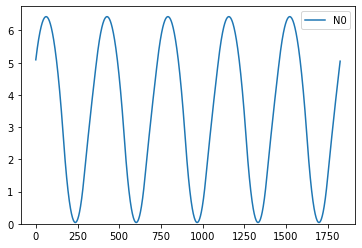

In [10]:
time = odeint_out.Time__time
plt.plot(time, odeint_out.N0__forcing_value, label='N0')
plt.ylim(bottom=0)
plt.legend()

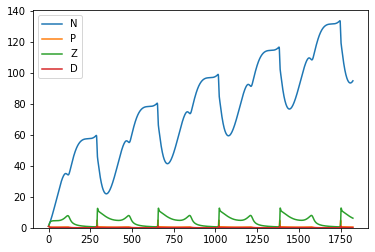

In [11]:
time = odeint_out.Time__time
plt.plot(time, odeint_out.Nutrient__var_value, label='N')
plt.plot(time, odeint_out.Phytoplankton__var_value, label='P')
plt.plot(time, odeint_out.Zooplankton__var_value, label='Z')
plt.plot(time, odeint_out.Detritus__var_value, label='D')
plt.ylim(bottom=0)
plt.legend()

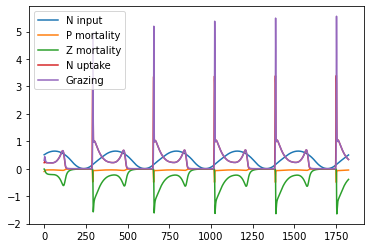

In [12]:
plt.plot(time, odeint_out.Input__input_value, label='N input')
plt.plot(time, -odeint_out.Mortality__death_value, label='P mortality')
plt.plot(time, -odeint_out.QuadMortality__death_value, label='Z mortality')
plt.plot(time, odeint_out.Growth__growth_value, label='N uptake')
plt.plot(time, odeint_out.Grazing__grazing_value, label='Grazing')
#plt.ylim(bottom=0)
plt.legend()

In [13]:
stepwise_setup = phydra.update_setup(model=NPZD, old_setup=odeint_setup, new_solver="stepwise",
                                     new_time=np.arange(0,365*5,.5))

In [14]:
with NPZD:
    stepwise_out = stepwise_setup.xsimlab.run()

initializing model backend
Initializing Model Time
Initializing component Nutrient
returning input arg dict defaultdict(<class 'list'>, {'vars': [{'var': 'var', 'label': 'N'}]})
defaultdict(<class 'list'>, {'vars': [{'var': 'var', 'label': 'N'}]})
Initializing component Phytoplankton
returning input arg dict defaultdict(<class 'list'>, {'vars': [{'var': 'var', 'label': 'P'}]})
defaultdict(<class 'list'>, {'vars': [{'var': 'var', 'label': 'P'}]})
Initializing component Zooplankton
returning input arg dict defaultdict(<class 'list'>, {'vars': [{'var': 'var', 'label': 'Z'}]})
defaultdict(<class 'list'>, {'vars': [{'var': 'var', 'label': 'Z'}]})
Initializing component Detritus
returning input arg dict defaultdict(<class 'list'>, {'vars': [{'var': 'var', 'label': 'D'}]})
defaultdict(<class 'list'>, {'vars': [{'var': 'var', 'label': 'D'}]})
Initializing component Tmld
returning input arg dict defaultdict(<class 'list'>, {'forcs': [{'var': 'forcing', 'label': 'Tmld'}], 'pars': [{'var': 'datas

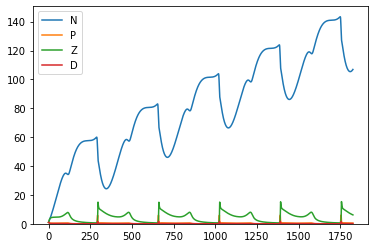

In [15]:
time = stepwise_out.Time__time
plt.plot(time, stepwise_out.Nutrient__var_value, label='N')
plt.plot(time, stepwise_out.Phytoplankton__var_value, label='P')
plt.plot(time, stepwise_out.Zooplankton__var_value, label='Z')
plt.plot(time, stepwise_out.Detritus__var_value, label='D')
plt.ylim(bottom=0)
plt.legend()

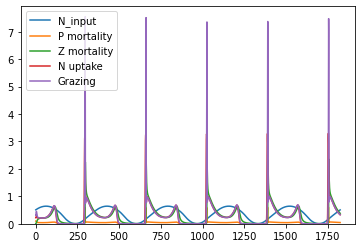

In [16]:
plt.plot(time, stepwise_out.Input__input_value, label='N_input')
plt.plot(time, stepwise_out.Mortality__death_value, label='P mortality')
plt.plot(time, stepwise_out.QuadMortality__death_value, label='Z mortality')
plt.plot(time, stepwise_out.Growth__growth_value, label='N uptake')
plt.plot(time, stepwise_out.Grazing__grazing_value, label='Grazing')
plt.ylim(bottom=0)
plt.legend()

In [17]:
gekko_setup = phydra.update_setup(model=NPZD, 
                                  old_setup=odeint_setup, 
                                  new_solver="gekko", 
                                  # gekko solver works better (much faster) with smaller time steps:
                                  new_time=np.arange(0,201,.1)
                                 )

In [18]:
with NPZD:
    gekko_out = gekko_setup.xsimlab.run()

initializing model backend
Initializing Model Time
Initializing component Nutrient
returning input arg dict defaultdict(<class 'list'>, {'vars': [{'var': 'var', 'label': 'N'}]})
defaultdict(<class 'list'>, {'vars': [{'var': 'var', 'label': 'N'}]})
Initializing component Phytoplankton
returning input arg dict defaultdict(<class 'list'>, {'vars': [{'var': 'var', 'label': 'P'}]})
defaultdict(<class 'list'>, {'vars': [{'var': 'var', 'label': 'P'}]})
Initializing component Zooplankton
returning input arg dict defaultdict(<class 'list'>, {'vars': [{'var': 'var', 'label': 'Z'}]})
defaultdict(<class 'list'>, {'vars': [{'var': 'var', 'label': 'Z'}]})
Initializing component Detritus
returning input arg dict defaultdict(<class 'list'>, {'vars': [{'var': 'var', 'label': 'D'}]})
defaultdict(<class 'list'>, {'vars': [{'var': 'var', 'label': 'D'}]})
Initializing component Tmld
returning input arg dict defaultdict(<class 'list'>, {'forcs': [{'var': 'forcing', 'label': 'Tmld'}], 'pars': [{'var': 'datas

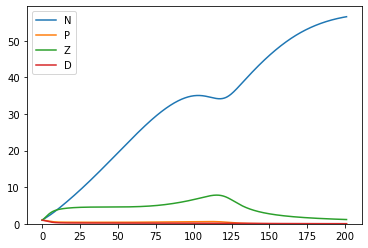

In [19]:
time = gekko_out.Time__time
plt.plot(time, gekko_out.Nutrient__var_value, label='N')
plt.plot(time, gekko_out.Phytoplankton__var_value, label='P')
plt.plot(time, gekko_out.Zooplankton__var_value, label='Z')
plt.plot(time, gekko_out.Detritus__var_value, label='D')
plt.ylim(bottom=0)
plt.legend()

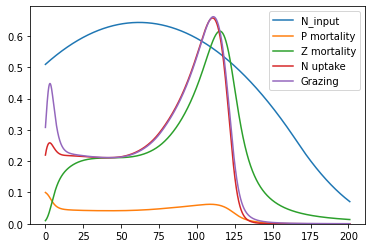

In [20]:
plt.plot(time, gekko_out.Input__input_value, label='N_input')
plt.plot(time, gekko_out.Mortality__death_value, label='P mortality')
plt.plot(time, gekko_out.QuadMortality__death_value, label='Z mortality')
plt.plot(time, gekko_out.Growth__growth_value, label='N uptake')
plt.plot(time, gekko_out.Grazing__grazing_value, label='Grazing')
plt.ylim(bottom=0)
plt.legend()